### Districts that preserve "communities of interest"


First we import our libraries and load the data files.  We'll use
census demographic data to quantify the community of interest.
Keeping the scope narrow, we'll just examine race and ethnicity, but
income, education level, or other indicators may be used.  We also
load current districts to evaluate how well they preserve communities
of interest.  When the redistricting commission produces new
districts, they may be evaluated, too.  Finally, we include census
data by county, which can validate our code more quickly because it
has many fewer areas to cluster.  



In [1]:
import os 
import pysal as ps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import region


def loaddata(filename, url):
    if not(os.path.isfile(filename+'.geojson')):
        print("Retrieving the data and storing to a file")
    #    req = requests.get(url, filename)
    #    tractdat = req.json()
    #    geojson knows how to read urls, so no need for requests module
        geodat = gpd.read_file(url)
        geodat.to_file(filename + '.geojson', driver='GeoJSON')
        geodat.to_file(filename)
    else:
        geodat = gpd.read_file(filename)
    #convert all to numeric where possible
    geodat = geodat.apply(pd.to_numeric, errors = 'ignore')
    #'pop' is not a good name for population
    if 'pop' in geodat.columns:
        geodat.rename({'pop':'population'}, axis = 'columns', inplace = True)

    return geodat
#tractdat.plot()
tractdat = loaddata('censustracts17','https://data.colorado.gov/resource/aevh-apr2.geojson?$limit=1300')
countydat = loaddata('censuscounties17','https://data.colorado.gov/resource/ewkj-ipn7.geojson')
currentdist = loaddata('censusdist','https://data.colorado.gov/resource/jz4n-qus2.geojson') 


C:\ProgramData\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


The datasets are missing data; the medians sometimes not defined for a
tract.  For now we won't use columns without data and later go back
and deal with nans using perhaps `DataFrame.fillna()`.  To start we'll
limit our analysis to communnities of interest defined by race and
ethnicity.  

In [2]:
print('The following columns have nan elements')
badcol = tractdat.columns[tractdat.isnull().any()]
print(list(badcol))


racecat = [ 'hispanic', 'white_nh', 'black_nh', 'ntvam_nh', 'asian_nh', 'hawpi_nh', 'other_nh', 'twoplus_nh']
#agecat = [i for i in tractdat.columns if 'age' in i and i not in badcol]
#incomecat = []
#all income categories have some nans!
#educationcat = [i for i in tractdat.columns if 'gr' in i and i not in badcol]
#educationcat.extend(['enrolled', 'n_enrolled'])


The following columns have nan elements
['med_age', 'med_fam_in', 'med_g_rent', 'avghhsize', 'med_hm_val', 'med_c_rent', 'med_hh_inc', 'med_yr_blt', 'per_cap_in']


First we'd like to answer the question "Where are the communities?"
The `max-p` algorithm divides a set of areas into regions with similar
characteristicts.  The number of regions is not set, but is chosen by
the algorithm to optimize intra-region similarity.  It does require a
minimum value for each region, in this case we'll say that each region
requires at least 250,000 people, about 5% of the state.  

Beginning maxp regionalization ...
... done.


KeyError: nan

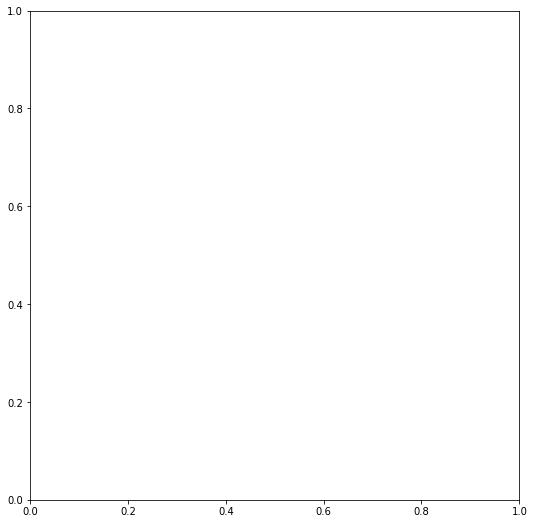

In [3]:
w = ps.queen_from_shapefile('censustracts17/censustracts17.shp', idVariable = 'geonum')
#w = ps.queen_from_shapefile('censuscounties17/censuscounties17.shp', idVariable = 'geonum')

z = tractdat[racecat].values
#z = countydat[racecat].values

print("Beginning maxp regionalization ...")
maxp = ps.region.Maxp(w, z, 500000 , tractdat.population, initial=300)
#maxp = ps.region.Maxp(w, z, 500000 , countydat.population, initial=300)
print("... done.")

lbls = pd.Series(maxp.area2region)

f, ax = plt.subplots(1, figsize=(9, 9))
#countydat.assign(cl=lbls.values).plot(column='cl',
tractdat.assign(cl=lbls.values).plot(column='cl',
                                     categorical=True,
                                     legend=True,
                                     linewidth=0.1,
                                     edgecolor='white',
                                     ax=ax)
ax.set_axis_off()
plt.show()

Of course these cannot be congressional districts.  There must be only
7 districts, one for each seat Colorado has in the House of
Representatives.  In addition, there must be close to equal population
in each district.  

Now we will use the AZP algorithm to generate a specific number of
districts.  The algorithm optimizes an objective function, which in this
case includes intra-region similarity and total population.  

In [4]:
ndist = 7
popweightfactor=1
tractdat.population = tractdat.population*popweightfactor

pregazp = region.p_regions.azp.AZP()
print("Beginning regionalization ...")
pregazp.fit_from_geodataframe(tractdat, ['population']+racecat, 
                              ndist, contiguity = "queen", 
                              objective_func = region.objective_function.ObjectiveFunctionPairwiseWithTotal() )
print("... done.")
tractdat.population = tractdat.population/popweightfactor

f, ax = plt.subplots(1, figsize=(9,9))
ctylabeled = tractdat.assign(cl = pregazp.labels_)
ctylabeled.plot(column = 'cl', 
                categorical = True, 
                legend = True, 
                linewidth = .1, 
                edgecolor = 'white', 
                ax = ax)
ax.set_axis_off()

Beginning regionalization ...
n_regions_per_comp {0: 7}
comp_label 0
n_regions_in_comp 7
Regions in comp: {0, 1, 2, 3, 4, 5, 6}


KeyboardInterrupt: 